In [ ]:
from concurrent.futures import ThreadPoolExecutor
import os
from PIL import Image
import numpy as np
import tqdm

# Define directories
source_dir1 = 'archive/similar/inpainting'
source_dir2 = 'sendyx/output8'
inpainting_dest = 'mask_images/inpainting'
original_dest = 'mask_images/original'

# Create destination directories
os.makedirs(original_dest, exist_ok=True)
os.makedirs(inpainting_dest, exist_ok=True)

def apply_mask(image_path, mask_path):
    """Apply mask to image"""
    image = Image.open(image_path).convert('RGBA')
    mask = Image.open(mask_path).convert('L')
    
    # Convert images to numpy arrays
    image_array = np.array(image)
    mask_array = np.array(mask)
    
    # Create an all transparent image
    result = np.zeros_like(image_array)
    
    # Copy only the pixels where the mask is white (255)
    result[mask_array == 255] = image_array[mask_array == 255]
    
    return Image.fromarray(result)

def process_folder_dir1(folder_path):
    """Process folder from first directory (only inpainting)"""
    folder_name = os.path.basename(folder_path)
    inpainting_file = os.path.join(folder_path, 'inpainting.png')
    original_file = os.path.join(folder_path, 'original.png')
    mask_file = os.path.join(folder_path, 'mask.png')
    
    if all(os.path.exists(f) for f in [inpainting_file, mask_file]):
        # Apply mask to inpainting image and save
        masked_inpainting = apply_mask(inpainting_file, mask_file)
        masked_original = apply_mask(original_file, mask_file)
        masked_inpainting.save(os.path.join(inpainting_dest, f'dir1_masked_inpainting_{folder_name}.png'))
        masked_original.save(os.path.join(original_dest, f'dir1_masked_original_{folder_name}.png'))
        return True
    return False

def process_folder_dir2(folder_path):
    """Process folder from second directory"""
    folder_name = os.path.basename(folder_path)
    original_file = os.path.join(folder_path, 'original.png')
    
    # Dictionary mapping mask types to their corresponding inpainting files
    mask_types = {
        'random_patch': ('mask_random_patch.png', 'inpainting_random_patch.png'),
        'top_left_black': ('mask_top_left_black.png', 'inpainting_top_left_black.png'),
        'top_left_white': ('mask_top_left_white.png', 'inpainting_top_left_white.png'),
        'top_right_black': ('mask_top_right_black.png', 'inpainting_top_right_black.png'),
        'top_right_white': ('mask_top_right_white.png', 'inpainting_top_right_white.png')
    }
    
    processed = 0
    if os.path.exists(original_file):
        # Process each mask type
        for mask_type, (mask_filename, inpainting_filename) in mask_types.items():
            mask_file = os.path.join(folder_path, mask_filename)
            inpainting_file = os.path.join(folder_path, inpainting_filename)
            
            if all(os.path.exists(f) for f in [mask_file, inpainting_file]):
                # Apply mask to original image and save
                masked_original = apply_mask(original_file, mask_file)
                masked_original.save(os.path.join(original_dest, 
                    f'dir2_{mask_type}_masked_original_{folder_name}.png'))
                
                # Apply mask to inpainting image and save
                masked_inpainting = apply_mask(inpainting_file, mask_file)
                masked_inpainting.save(os.path.join(inpainting_dest, 
                    f'dir2_{mask_type}_masked_inpainting_{folder_name}.png'))
                
                processed += 1
    
    return processed

def process_directories():
    """Process both directories"""
    # Get list of folders from both directories
    folders_dir1 = [os.path.join(source_dir1, d) for d in os.listdir(source_dir1) 
                if os.path.isdir(os.path.join(source_dir1, d))]
    folders_dir2 = [os.path.join(source_dir2, d) for d in os.listdir(source_dir2) 
                if os.path.isdir(os.path.join(source_dir2, d))]
    
    processed_dir1 = 0
    processed_dir2 = 0
    
    # Process directory 1 (inpainting only)
    with ThreadPoolExecutor() as executor:
        results = list(tqdm.tqdm(executor.map(process_folder_dir1, folders_dir1), 
                            total=len(folders_dir1), 
                            desc="Processing directory 1"))
        processed_dir1 = sum(results)
    
    # Process directory 2 (both original and inpainting)
    with ThreadPoolExecutor() as executor:
        results = list(tqdm.tqdm(executor.map(process_folder_dir2, folders_dir2), 
                            total=len(folders_dir2), 
                            desc="Processing directory 2"))
        processed_dir2 = sum(results)
    
    return processed_dir1, processed_dir2

# Run the processing
processed_dir1, processed_dir2 = process_directories()
print(f"Directory 1: Processed {processed_dir1} inpainting images")
print(f"Directory 2: Processed {processed_dir2} mask-inpainting pairs")

Processing directory 2:  27%|██▋       | 439/1650 [02:02<03:40,  5.50it/s]

In [6]:
import cv2
def load_image_paths_from_folder(folder, label):
    image_paths = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith((".png", ".jpg", ".jpeg")):
            img_path = os.path.join(folder, filename)
            image_paths.append(img_path)
            labels.append(label)
    return image_paths, labels

# Load real image paths (label = 1)
# real_folder = "extracted_images/original"
real_folder = "mask_images/original"
real_image_paths, real_labels = load_image_paths_from_folder(real_folder, label=1)

# Load fake image paths (label = 0)
# fake_folder = "extracted_images/inpainting"
fake_folder = "mask_images/inpainting"
fake_image_paths, fake_labels = load_image_paths_from_folder(fake_folder, label=0)

# Combine real and fake image paths and labels
image_paths = real_image_paths + fake_image_paths
labels = real_labels + fake_labels

# Convert labels to NumPy array
labels = np.array(labels)

# Check number of images loaded
print(f"Number of real images: {len(real_image_paths)}")
print(f"Number of fake images: {len(fake_image_paths)}")
print(f"Total number of images: {len(image_paths)}")

# Function to load and preprocess images (to be used when training the model)
def load_and_preprocess_image(image_path, target_size=(256, 256), preserve_texture=True):
    img = Image.open(image_path)
    img = img.convert('RGB')  # Convert to RGB
    if preserve_texture:
        # Convert to numpy array for OpenCV processing
        img_array = np.array(img)
        
        # Use Lanczos resampling which better preserves high-frequency details
        img_array = cv2.resize(
            img_array, 
            target_size, 
            interpolation=cv2.INTER_LANCZOS4
        )
    else:
        img = img.resize(target_size)  # Resize the image
        img_array = np.array(img)

    img_array = img_array.astype(np.float32)
    img_array /= 255.0  # Normalize to [0, 1]
    return img_array

Number of real images: 5063
Number of fake images: 5063
Total number of images: 10126


In [7]:
from numpy import random
# Test the preprocessing function
test_image_path = random.choice(image_paths)  # Choose a random image
processed_image = load_and_preprocess_image(test_image_path)

print(f"Processed image shape: {processed_image.shape}")
print(f"Min pixel value: {processed_image.min()}")
print(f"Max pixel value: {processed_image.max()}")
print(f"Mean pixel value: {processed_image.mean()}")

Processed image shape: (256, 256, 3)
Min pixel value: 0.0
Max pixel value: 1.0
Mean pixel value: 0.24677468836307526


In [8]:
from sklearn.model_selection import train_test_split
# Perform train-test split
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# Print the shapes of the resulting datasets
print("\nAfter train-test split:")
print(f"Train set size: {len(train_paths)}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test set size: {len(test_paths)}")
print(f"Test labels shape: {test_labels.shape}")

# Print the distribution of labels in train and test sets
print(f"\nTrain set - Real: {np.sum(train_labels == 1)}, Fake: {np.sum(train_labels == 0)}")
print(f"Test set - Real: {np.sum(test_labels == 1)}, Fake: {np.sum(test_labels == 0)}")


After train-test split:
Train set size: 8100
Train labels shape: (8100,)
Test set size: 2026
Test labels shape: (2026,)

Train set - Real: 4050, Fake: 4050
Test set - Real: 1013, Fake: 1013


In [9]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2

def improved_deepfake_detection_model(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)
    
    # Convolutional layers
    x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Additional convolutional layer
    x = Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)
    
    # Dense layers
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.6)(x)
    
    # Final layer
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create the model
model = improved_deepfake_detection_model()

# Print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 batch_normalization_8 (Bat  (None, 256, 256, 32)      128       
 chNormalization)                                                
                                                                 
 activation_9 (Activation)   (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 64)      18496 

In [109]:
from tensorflow.keras.optimizers import Adam


model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00025), metrics=['accuracy'])
# train_gen = ImageDataGenerator(  preprocessing_function=lambda x: x / 255.0  # Normalize pixel values
# )

train_gen = ImageDataGenerator(
    rotation_range=5,    
    width_shift_range=0.1,     
    height_shift_range=0.1,
    horizontal_flip=False,  
    zoom_range=0.1,
    shear_range=0.0, 
    fill_mode='constant',  
    cval=0,                   # Black padding for constant fill mode
)

# train_gen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     zoom_range=0.2,
#     shear_range=0.2,
#     fill_mode='nearest'
# )

test_gen = ImageDataGenerator()

# Custom generator function
def custom_generator(features, labels, batch_size, gen, is_training=False, target_size=(256, 256)):
    while True:
        batch_indices = np.random.choice(len(features), batch_size)
        batch_features = np.array([load_and_preprocess_image(features[i], target_size) for i in batch_indices])
        batch_labels = labels[batch_indices]
        
        # Apply data augmentation only for training generator
        if is_training:
            batch_features, batch_labels = next(gen.flow(batch_features, batch_labels, batch_size=batch_size))
        
        yield batch_features, batch_labels

# Create generators
train_generator = custom_generator(train_paths, train_labels, batch_size=32, gen=train_gen, is_training=True, target_size=(256, 256))
test_generator = custom_generator(test_paths, test_labels, batch_size=32, gen=test_gen, is_training=False, target_size=(256, 256))

In [110]:
# Test the custom generator
train_generator = custom_generator(train_paths, train_labels, batch_size=32, gen=train_gen, is_training=True, target_size=(256, 256))
test_generator = custom_generator(test_paths, test_labels, batch_size=32, gen=test_gen, is_training=False, target_size=(256, 256))

# Check a batch from each generator
train_batch_x, train_batch_y = next(train_generator)
test_batch_x, test_batch_y = next(test_generator)

print("Training batch:")
print(f"X shape: {train_batch_x.shape}, Y shape: {train_batch_y.shape}")
print(f"X min: {train_batch_x.min()}, X max: {train_batch_x.max()}, X mean: {train_batch_x.mean()}")
print(f"Y values: {np.unique(train_batch_y)}")

print("\nTesting batch:")
print(f"X shape: {test_batch_x.shape}, Y shape: {test_batch_y.shape}")
print(f"X min: {test_batch_x.min()}, X max: {test_batch_x.max()}, X mean: {test_batch_x.mean()}")
print(f"Y values: {np.unique(test_batch_y)}")

Training batch:
X shape: (32, 256, 256, 3), Y shape: (32,)
X min: 0.0, X max: 1.0, X mean: 0.20433689653873444
Y values: [0 1]

Testing batch:
X shape: (32, 256, 256, 3), Y shape: (32,)
X min: 0.0, X max: 1.0, X mean: 0.24954169988632202
Y values: [0 1]


In [112]:
import tensorflow as tf

class GradientCheck(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        weights = self.model.get_weights()
        has_nan = any(np.isnan(w).any() for w in weights)
        has_inf = any(np.isinf(w).any() for w in weights)
        print(f"Epoch {epoch+1}: NaN in weights: {has_nan}, Inf in weights: {has_inf}")

class LayerOutputCheck(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Get the output of the last layer (which should be the sigmoid output)
        layer_output = tf.keras.backend.function([self.model.input], [self.model.output])
        sample_data, sample_labels = next(train_generator)  # Get a batch of data and labels
        output = layer_output([sample_data])[0]
        
        # Calculate accuracy on this batch
        predicted_classes = (output > 0.5).astype(int)
        accuracy = np.mean(predicted_classes == sample_labels)
        
        print(f"Epoch {epoch+1}: Output range: {output.min():.4f} to {output.max():.4f}, Mean: {output.mean():.4f}")
        print(f"Batch accuracy: {accuracy:.4f}")
        print(f"Output distribution: {np.sum(output < 0.1)} < 0.1, {np.sum((output >= 0.1) & (output < 0.9))} in [0.1, 0.9), {np.sum(output >= 0.9)} >= 0.9")

class PrintProgress(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}: loss: {logs['loss']:.4f} - accuracy: {logs['accuracy']:.4f} - val_loss: {logs['val_loss']:.4f} - val_accuracy: {logs['val_accuracy']:.4f}")

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

# Create a directory to save model weights if it doesn't exist
weights_dir = "model_weights"
os.makedirs(weights_dir, exist_ok=True)

# Define the file path for saving the model weights
checkpoint_filepath = os.path.join(weights_dir, "model_weights_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.weights.h5")

# Create a ModelCheckpoint callback to save the best model weights
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # Save only weights, not the entire model
    save_best_only=True,  # Only save the best model
    monitor='val_loss',  # Metric to monitor
    mode='min',  # 'min' for loss, 'max' for accuracy
    verbose=1
)

# Create an EarlyStopping callback to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,
    verbose=1
)

# Create a ReduceLROnPlateau callback to reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,  # Factor by which the learning rate will be reduced
    patience=2,  # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,  # Lower bound on the learning rate
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_paths) // 32,
    epochs=25,
    validation_data=test_generator,
    validation_steps=len(test_paths) // 32,
    callbacks=[model_checkpoint_callback, early_stopping, reduce_lr, GradientCheck(), LayerOutputCheck(), PrintProgress()]
)

# Save the final model weights
final_weights_path = os.path.join(weights_dir, "final_model_weights.weights.h5")
model.save_weights(final_weights_path)
print(f"Final model weights saved to {final_weights_path}")

Epoch 1/25
 11/253 [>.............................] - ETA: 4:50 - loss: 1.0240 - accuracy: 0.5511

KeyboardInterrupt: 

In [15]:
model = improved_deepfake_detection_model()  # Your model definition function
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
path_to_weight = 'model_weights_epoch_04_val_loss_0.57.weights.h5'
model.load_weights(f'model_weights/{path_to_weight}')

In [14]:
def test_generator(image_paths, labels, batch_size=32):
    num_samples = len(image_paths)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_paths = image_paths[offset:offset+batch_size]
            batch_labels = labels[offset:offset+batch_size]
            
            batch_images = np.array([load_and_preprocess_image(path) for path in batch_paths])
            
            yield batch_images, batch_labels

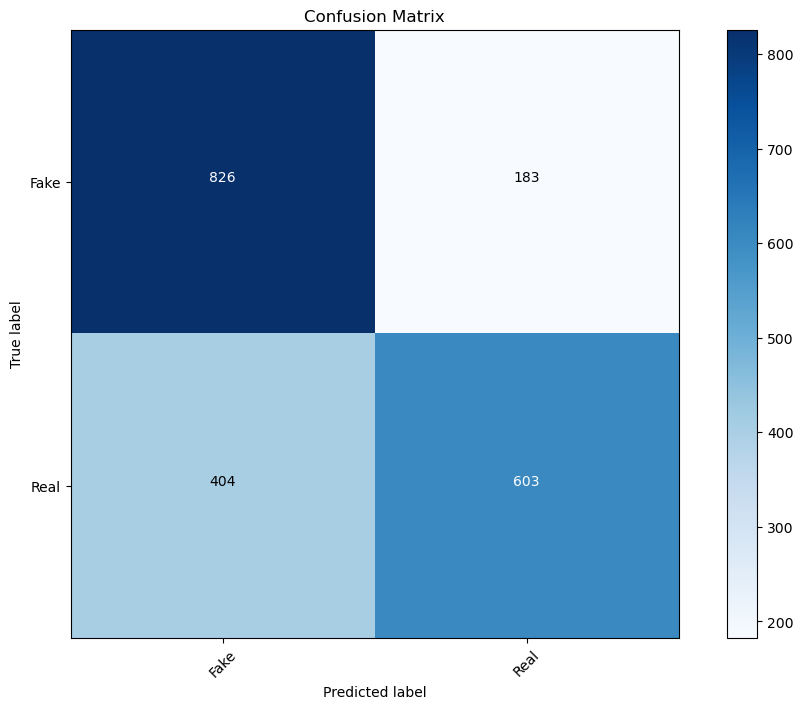


Classification Report:
              precision    recall  f1-score   support

        Fake       0.67      0.82      0.74      1009
        Real       0.77      0.60      0.67      1007

    accuracy                           0.71      2016
   macro avg       0.72      0.71      0.71      2016
weighted avg       0.72      0.71      0.71      2016


Accuracy: 0.7088
AUC-ROC: 0.7885


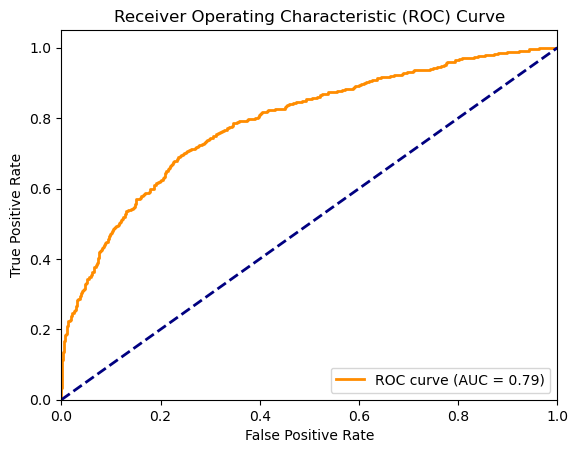

In [16]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve

# Function to get predictions and true labels
def get_predictions_and_labels(generator, num_samples, batch_size):
    steps = num_samples // batch_size
    y_pred = []
    y_true = []
    for _ in range(steps):
        batch_x, batch_y = next(generator)
        batch_pred = model.predict(batch_x, verbose=0)
        y_pred.extend(batch_pred)
        y_true.extend(batch_y)
    return np.array(y_pred).flatten(), np.array(y_true)

# Create the test generator
test_gen = test_generator(test_paths, test_labels, batch_size=32)

# Get predictions and true labels
num_test_samples = len(test_paths)
y_pred, y_true = get_predictions_and_labels(test_gen, num_test_samples, batch_size=32)

# Convert predictions to classes
y_pred_classes = (y_pred > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10,7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Fake', 'Real'], rotation=45)
plt.yticks(tick_marks, ['Fake', 'Real'])

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=['Fake', 'Real']))

# Print accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"\nAccuracy: {accuracy:.4f}")

# Print AUC-ROC
auc_roc = roc_auc_score(y_true, y_pred)
print(f"AUC-ROC: {auc_roc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

1/1 [==============================] - 0s 295ms/step


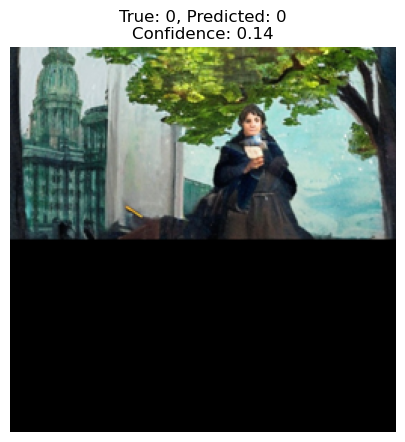

1/1 [==============================] - 0s 17ms/step


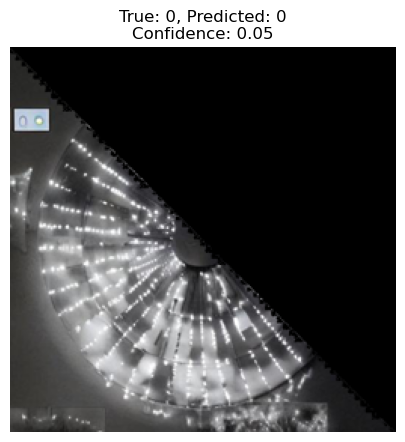

1/1 [==============================] - 0s 15ms/step


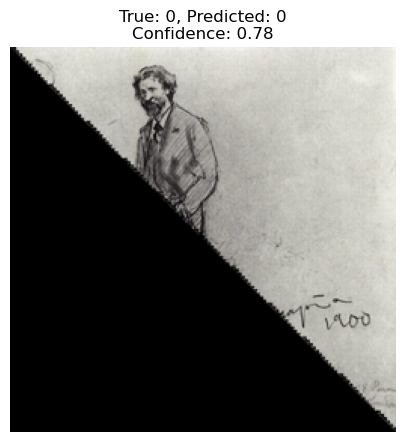

1/1 [==============================] - 0s 17ms/step


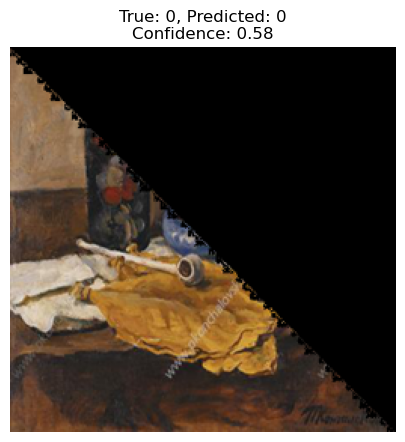

1/1 [==============================] - 0s 17ms/step


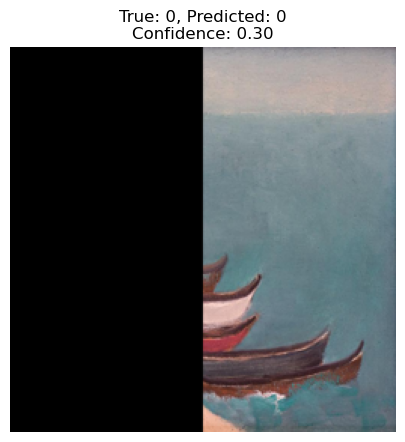

1/1 [==============================] - 0s 20ms/step


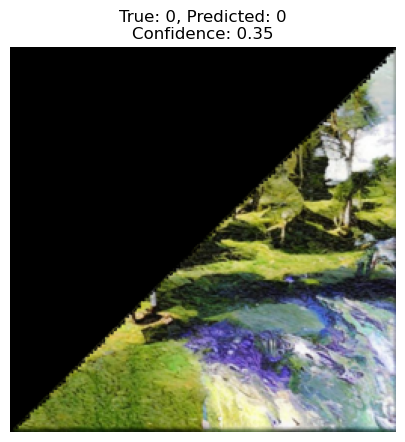

1/1 [==============================] - 0s 15ms/step


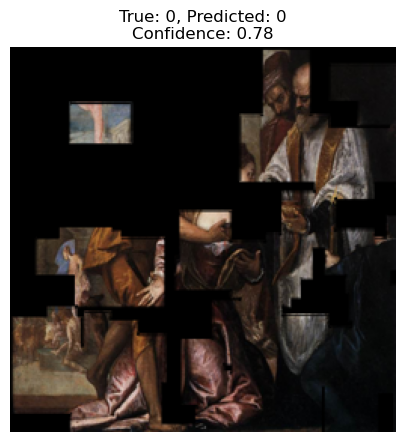

1/1 [==============================] - 0s 16ms/step


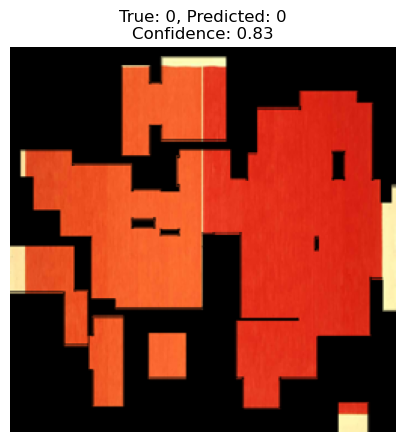

1/1 [==============================] - 0s 20ms/step


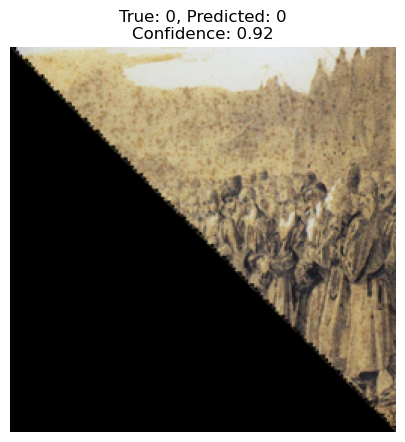

1/1 [==============================] - 0s 15ms/step


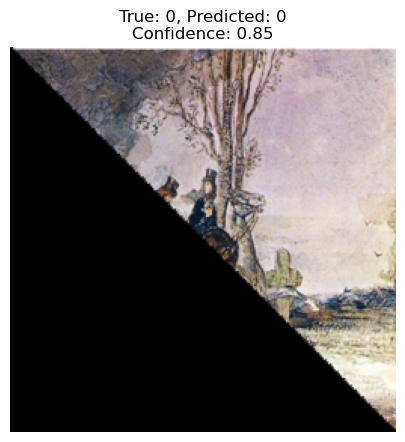

In [20]:
def visualize_predictions(model, test_paths, test_labels, num_samples=10):
    # Randomly select samples
    indices = np.random.choice(len(test_paths), num_samples, replace=False)
    
    for idx in indices:
        # Load and preprocess the image
        img = load_and_preprocess_image(test_paths[idx])
        img_batch = np.expand_dims(img, axis=0)
        
        # Make prediction
        prediction = model.predict(img_batch)[0]
        predicted_class = np.argmax(prediction)
        true_class = np.argmax(test_labels[idx])
        
        # Display the image and prediction
        plt.figure(figsize=(10, 5))
        plt.imshow(img)
        plt.title(f"True: {true_class}, Predicted: {predicted_class}\nConfidence: {prediction[predicted_class]:.2f}")
        plt.axis('off')
        plt.show()

# Call the function
visualize_predictions(model, test_paths, test_labels)

<b>Load weights and extract features for SVM Classification:</b>
- run code up till intialise CNN model part, then set weight for model layers

In [17]:
# view keys for 0.60 weights
import h5py

with h5py.File('model_weights_cnn/model_weights_epoch_05_val_loss_0.60.weights.h5', 'r') as h5file:
    print("Keys in the file:")
    for key in h5file.keys():
        print(key)

Keys in the file:
activation_4
activation_5
activation_6
activation_7
batch_normalization_10
batch_normalization_11
batch_normalization_6
batch_normalization_7
batch_normalization_8
batch_normalization_9
conv2d_4
conv2d_5
conv2d_6
conv2d_7
dense_3
dense_4
dense_5
dropout_2
dropout_3
global_average_pooling2d_1
input_2
max_pooling2d_4
max_pooling2d_5
max_pooling2d_6
max_pooling2d_7
top_level_model_weights


In [ ]:
# view keys for 0.57 weights
import h5py

with h5py.File('model_weights_cnn/model_weights_epoch_04_val_loss_0.57.weights.h5', 'r') as h5file:
    print("Keys in the file:")
    for key in h5file.keys():
        print(key)

In [172]:
# loading weights

with h5py.File('model_weights_cnn/model_weights_epoch_05_val_loss_0.60.weights.h5', 'r') as h5file:
    weights_group = h5file['top_level_model_weights']
    
    # Iterate over the layers in the model and set weights
    for layer in model.layers:
        if layer.name in weights_group:
            layer_weights = [weights_group[layer.name][w] for w in weights_group[layer.name]]
            layer.set_weights(layer_weights)

print("Weights loaded successfully!")

Weights loaded successfully!


In [ ]:
model.summary()

<b>Testing conv2d_10 layer</b>

In [15]:
# Function to extract features using the CNN
def extract_features(image_paths, model):
    features = []
    for img_path in image_paths:
        img_array = load_and_preprocess_image(img_path, target_size=(256, 256))
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Extract features
        feature = model.predict(img_array)
        features.append(feature.flatten()) 
    return np.array(features)

# Extract features from convolutional layer
# Change this accordingly to the conv layer u wan to extract
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('global_average_pooling2d').output)

# Extract features
features = extract_features(image_paths, feature_extractor)

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step


In [ ]:
np.save('global_average_pooling2d.npy', features)  # Saves as a .npy file
print("saved")
features_conv2d_10

In [ ]:
# can try PCA afterwards, run above without PCA first // can adjust variance %

import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score


train_paths, test_paths, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

# Step 2: Standardize the features
scaler = StandardScaler()
train_paths = scaler.fit_transform(train_paths)
test_paths = scaler.transform(test_paths)

# Step 3: Apply PCA
pca = PCA(n_components=0.85)  # Retain 85% of the variance
train_paths = pca.fit_transform(train_paths)
test_paths = pca.transform(test_paths)

In [17]:
from sklearn.svm import SVC

model_map = {"svm_linear": SVC(kernel = "linear"),
             "svm_rbf": SVC(kernel = "rbf"),
            "svm_poly": SVC(kernel = "poly")}

parameters_map = { 
    "C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],  # Further expanded range
    "gamma": [0.0001, 0.001, 0.01, 0.1, 1, 10],  # Further expanded range
    "degree": [2, 3, 4, 5, 6]  # Added more degrees for poly kernel
}


def fine_tune(model: str, param_grid: dict, folds:int = 3):
    return HalvingGridSearchCV(model_map[model], param_grid, n_jobs = -1, refit = True, cv = folds, verbose = 3, factor = 3, resource = "n_samples")

In [232]:
# linear

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV

linear_svm = fine_tune("svm_linear", parameters_map)
linear_svm.fit(train_paths, train_labels)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 100
max_resources_: 8100
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 240
n_resources: 100
Fitting 3 folds for each of 240 candidates, totalling 720 fits


python(77522) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(77523) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(77524) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(77525) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(77526) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(77527) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(77528) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(77529) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


KeyboardInterrupt: 

In [179]:
print(f"Grid search linear SVM best parameters: {linear_svm.best_params_}")
print(f"Cross validated score of the best linear SVM model: {linear_svm.best_score_}")

Grid search linear SVM best parameters: {'C': 1, 'degree': 4, 'gamma': 0.1}
Cross validated score of the best linear SVM model: 0.6830864197530865


In [180]:
y_pred = linear_svm.predict(test_paths)

In [182]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred)  
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate precision, recall, and F1 score
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 66.49%
Confusion Matrix:
[[704 309]
 [370 643]]
Precision: 0.68
Recall: 0.63
F1 Score: 0.65


In [201]:
# polynomial

poly_svm = fine_tune("svm_poly", parameters_map)
poly_svm.fit(train_paths, train_labels)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 100
max_resources_: 8100
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 240
n_resources: 100
Fitting 3 folds for each of 240 candidates, totalling 720 fits
----------
iter: 1
n_candidates: 80
n_resources: 300
Fitting 3 folds for each of 80 candidates, totalling 240 fits
----------
iter: 2
n_candidates: 27
n_resources: 900
Fitting 3 folds for each of 27 candidates, totalling 81 fits
----------
iter: 3
n_candidates: 9
n_resources: 2700
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 4
n_candidates: 3
n_resources: 8100
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END C=0.0001, degree=2, gamma=0.01;, score=(train=0.591, test=0.333) total time=   0.0s
[CV 3/3] END C=0.0001, degree=2, gamma=0.01;, score=(train=0.606, test=0.576) total time=   0.0s
[CV 2/3] END C=0.0001, degree=2, gamma=1;, score=(train=0.621, test=0.455) total time=  

[CV 1/3] END C=0.0001, degree=2, gamma=0.001;, score=(train=0.591, test=0.333) total time=   0.0s
[CV 1/3] END C=0.0001, degree=2, gamma=1;, score=(train=0.591, test=0.333) total time=   0.0s
[CV 3/3] END C=0.0001, degree=3, gamma=10;, score=(train=0.606, test=0.576) total time=   0.0s
[CV 3/3] END C=0.0001, degree=4, gamma=0.0001;, score=(train=0.606, test=0.576) total time=   0.0s
[CV 1/3] END C=0.0001, degree=4, gamma=1;, score=(train=0.591, test=0.333) total time=   0.0s
[CV 2/3] END C=0.0001, degree=4, gamma=1;, score=(train=0.621, test=0.455) total time=   0.0s
[CV 2/3] END C=0.0001, degree=5, gamma=0.001;, score=(train=0.621, test=0.455) total time=   0.0s
[CV 3/3] END C=0.0001, degree=5, gamma=0.001;, score=(train=0.606, test=0.576) total time=   0.0s
[CV 1/3] END C=0.001, degree=6, gamma=0.01;, score=(train=0.591, test=0.333) total time=   0.0s
[CV 2/3] END C=0.001, degree=6, gamma=0.01;, score=(train=0.621, test=0.455) total time=   0.0s
[CV 3/3] END C=0.001, degree=6, gamma=

[CV 1/3] END C=0.0001, degree=2, gamma=0.0001;, score=(train=0.591, test=0.333) total time=   0.0s
[CV 3/3] END C=0.0001, degree=2, gamma=1;, score=(train=0.606, test=0.576) total time=   0.0s
[CV 2/3] END C=0.0001, degree=3, gamma=0.0001;, score=(train=0.621, test=0.455) total time=   0.0s
[CV 2/3] END C=0.0001, degree=3, gamma=0.001;, score=(train=0.621, test=0.455) total time=   0.0s
[CV 1/3] END C=0.0001, degree=3, gamma=0.1;, score=(train=0.591, test=0.333) total time=   0.0s
[CV 3/3] END C=0.0001, degree=3, gamma=1;, score=(train=0.606, test=0.576) total time=   0.0s
[CV 1/3] END C=0.0001, degree=4, gamma=0.01;, score=(train=0.591, test=0.333) total time=   0.0s
[CV 2/3] END C=0.0001, degree=4, gamma=0.01;, score=(train=0.621, test=0.455) total time=   0.0s
[CV 1/3] END C=0.0001, degree=6, gamma=0.0001;, score=(train=0.591, test=0.333) total time=   0.0s
[CV 2/3] END C=0.0001, degree=6, gamma=0.0001;, score=(train=0.621, test=0.455) total time=   0.0s
[CV 3/3] END C=0.0001, degre

[CV 2/3] END C=0.0001, degree=2, gamma=0.0001;, score=(train=0.621, test=0.455) total time=   0.0s
[CV 2/3] END C=0.0001, degree=3, gamma=1;, score=(train=0.621, test=0.455) total time=   0.0s
[CV 2/3] END C=0.0001, degree=4, gamma=0.001;, score=(train=0.621, test=0.455) total time=   0.0s
[CV 3/3] END C=0.0001, degree=4, gamma=0.001;, score=(train=0.606, test=0.576) total time=   0.0s
[CV 3/3] END C=0.0001, degree=4, gamma=1;, score=(train=0.606, test=0.576) total time=   0.0s
[CV 1/3] END C=0.0001, degree=4, gamma=10;, score=(train=0.591, test=0.333) total time=   0.0s
[CV 1/3] END C=0.0001, degree=5, gamma=0.0001;, score=(train=0.591, test=0.333) total time=   0.0s
[CV 2/3] END C=0.0001, degree=5, gamma=0.0001;, score=(train=0.621, test=0.455) total time=   0.0s
[CV 1/3] END C=0.0001, degree=5, gamma=1;, score=(train=0.591, test=0.333) total time=   0.0s
[CV 2/3] END C=0.0001, degree=5, gamma=1;, score=(train=0.621, test=0.455) total time=   0.0s
[CV 2/3] END C=0.0001, degree=6, gam

HalvingGridSearchCV(cv=3, estimator=SVC(kernel='poly'), n_jobs=-1,
                    param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                      1000],
                                'degree': [2, 3, 4, 5, 6],
                                'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
                    verbose=3)

[CV 2/3] END C=0.0001, degree=2, gamma=0.01;, score=(train=0.621, test=0.455) total time=   0.0s
[CV 3/3] END C=0.0001, degree=2, gamma=0.1;, score=(train=0.606, test=0.576) total time=   0.0s
[CV 1/3] END C=0.0001, degree=2, gamma=10;, score=(train=0.591, test=0.333) total time=   0.0s
[CV 1/3] END C=0.01, degree=2, gamma=1;, score=(train=0.591, test=0.333) total time=   0.0s
[CV 2/3] END C=0.01, degree=2, gamma=1;, score=(train=0.621, test=0.455) total time=   0.0s
[CV 3/3] END C=0.01, degree=2, gamma=1;, score=(train=0.606, test=0.576) total time=   0.0s
[CV 1/3] END C=0.01, degree=2, gamma=10;, score=(train=0.591, test=0.333) total time=   0.0s
[CV 2/3] END C=0.01, degree=2, gamma=10;, score=(train=0.621, test=0.455) total time=   0.0s
[CV 3/3] END C=0.01, degree=2, gamma=10;, score=(train=0.606, test=0.576) total time=   0.0s
[CV 1/3] END C=0.01, degree=3, gamma=0.0001;, score=(train=0.591, test=0.333) total time=   0.0s
[CV 2/3] END C=0.01, degree=3, gamma=0.0001;, score=(train=0

[CV 2/3] END C=0.0001, degree=2, gamma=0.001;, score=(train=0.621, test=0.455) total time=   0.0s
[CV 1/3] END C=0.0001, degree=2, gamma=0.1;, score=(train=0.591, test=0.333) total time=   0.0s
[CV 2/3] END C=0.0001, degree=2, gamma=10;, score=(train=0.621, test=0.455) total time=   0.0s
[CV 3/3] END C=0.0001, degree=3, gamma=0.0001;, score=(train=0.606, test=0.576) total time=   0.0s
[CV 1/3] END C=0.0001, degree=3, gamma=0.01;, score=(train=0.591, test=0.333) total time=   0.0s
[CV 2/3] END C=0.0001, degree=3, gamma=0.1;, score=(train=0.621, test=0.455) total time=   0.0s
[CV 2/3] END C=0.0001, degree=4, gamma=0.1;, score=(train=0.621, test=0.455) total time=   0.0s
[CV 3/3] END C=0.0001, degree=4, gamma=0.1;, score=(train=0.606, test=0.576) total time=   0.0s
[CV 1/3] END C=0.0001, degree=5, gamma=0.01;, score=(train=0.591, test=0.333) total time=   0.0s
[CV 2/3] END C=0.0001, degree=5, gamma=0.01;, score=(train=0.621, test=0.455) total time=   0.0s
[CV 3/3] END C=0.0001, degree=5, 

In [202]:
print(f"Grid search poly SVM best parameters: {poly_svm.best_params_}")
print(f"Cross validated score of the best poly SVM model: {poly_svm.best_score_}")

Grid search poly SVM best parameters: {'C': 0.001, 'degree': 3, 'gamma': 1}
Cross validated score of the best poly SVM model: 0.675679012345679


In [203]:
y_pred_poly = poly_svm.predict(test_paths)

In [205]:
# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred_poly)  
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred_poly)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate precision, recall, and F1 score
precision = precision_score(test_labels, y_pred_poly)
recall = recall_score(test_labels, y_pred_poly)
f1 = f1_score(test_labels, y_pred_poly)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 66.04%
Confusion Matrix:
[[734 279]
 [409 604]]
Precision: 0.68
Recall: 0.60
F1 Score: 0.64


In [183]:
# rbf

rbf_svm = fine_tune("svm_rbf", parameters_map)
rbf_svm.fit(train_paths, train_labels)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 100
max_resources_: 8100
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 240
n_resources: 100
Fitting 3 folds for each of 240 candidates, totalling 720 fits
----------
iter: 1
n_candidates: 80
n_resources: 300
Fitting 3 folds for each of 80 candidates, totalling 240 fits
----------
iter: 2
n_candidates: 27
n_resources: 900
Fitting 3 folds for each of 27 candidates, totalling 81 fits
----------
iter: 3
n_candidates: 9
n_resources: 2700
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 4
n_candidates: 3
n_resources: 8100
Fitting 3 folds for each of 3 candidates, totalling 9 fits


HalvingGridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
                    param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                      1000],
                                'degree': [2, 3, 4, 5, 6],
                                'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
                    verbose=3)

In [184]:
# Check the best parameters
print("Best parameters found:", rbf_svm.best_params_)

# Check the kernel of the best estimator
print("Kernel used:", rbf_svm.best_estimator_.kernel)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 100
max_resources_: 8100
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 240
n_resources: 100
Fitting 3 folds for each of 240 candidates, totalling 720 fits
----------
iter: 1
n_candidates: 80
n_resources: 300
Fitting 3 folds for each of 80 candidates, totalling 240 fits
----------
iter: 2
n_candidates: 27
n_resources: 900
Fitting 3 folds for each of 27 candidates, totalling 81 fits
----------
iter: 3
n_candidates: 9
n_resources: 2700
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 4
n_candidates: 3
n_resources: 8100
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best parameters found: {'C': 100, 'degree': 5, 'gamma': 0.001}
Kernel used: rbf


In [185]:
y_pred_rbf = rbf_svm.predict(test_paths)

In [207]:
# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred_rbf)  
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred_rbf)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate precision, recall, and F1 score
precision = precision_score(test_labels, y_pred_rbf)
recall = recall_score(test_labels, y_pred_rbf)
f1 = f1_score(test_labels, y_pred_rbf)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 70.34%
Confusion Matrix:
[[779 234]
 [367 646]]
Precision: 0.73
Recall: 0.64
F1 Score: 0.68


In [135]:
# testing out ensemble model (catboost + rbf) // 69.79% compared to just rbf of 70.34%

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

# Define the parameter grid for SVC
svc_parameters_map = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'degree': [2, 3, 4, 5],
    'probability': [True]  
}

rbf_svm = SVC(kernel='rbf')

rbf_svm = HalvingGridSearchCV(
    estimator=rbf_svm,
    param_grid=svc_parameters_map,
    n_jobs=-1,
    refit=True,
    cv=3,
    verbose=3,
    factor=3,
    resource='n_samples'
)

rbf_svm.fit(train_paths, train_labels)

catboost_parameters_map = {
    'iterations': [100, 200],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1],
    'l2_leaf_reg': [1, 3, 5]
}

cat_clf = CatBoostClassifier(verbose=0, random_state=42)

catboost_search = HalvingGridSearchCV(
    estimator=cat_clf,
    param_grid=catboost_parameters_map,
    n_jobs=-1,
    refit=True,
    cv=3,
    verbose=3,
    factor=3,
    resource='n_samples'
)

catboost_search.fit(train_paths, train_labels)

# Create the ensemble model (Voting Classifier)
voting_clf = VotingClassifier(
    estimators=[
        ('cat', catboost_search.best_estimator_),
        ('rbf', rbf_svm.best_estimator_)
    ],
    voting='soft'
)

# Train the ensemble model
voting_clf.fit(train_paths, train_labels)

# Make predictions
y_pred = voting_clf.predict(test_paths)

# Evaluate the ensemble model
accuracy = accuracy_score(test_labels, y_pred)
print(f"Ensemble Model Accuracy: {accuracy}")

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 100
max_resources_: 8100
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 112
n_resources: 100
Fitting 3 folds for each of 112 candidates, totalling 336 fits
----------
iter: 1
n_candidates: 38
n_resources: 300
Fitting 3 folds for each of 38 candidates, totalling 114 fits
----------
iter: 2
n_candidates: 13
n_resources: 900
Fitting 3 folds for each of 13 candidates, totalling 39 fits
----------
iter: 3
n_candidates: 5
n_resources: 2700
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 4
n_candidates: 2
n_resources: 8100
Fitting 3 folds for each of 2 candidates, totalling 6 fits
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 300
max_resources_: 8100
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 36
n_resources: 300
Fitting 3 folds for each of 36 candidates, totalling 108 fits
----------
iter: 1
n

<b>Testing conv2d_10 layer</b>

In [ ]:
from tensorflow.keras.models import Model

# Function to extract features using the CNN
def extract_features(image_paths, model):
    features = []
    for img_path in image_paths:
        img_array = load_and_preprocess_image(img_path, target_size=(256, 256))
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Extract features
        feature = model.predict(img_array)
        features.append(feature.flatten())  # Flatten if necessary
    return np.array(features)

# extract features, from conv2d_9 layer
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('conv2d_10').output)

# Extract features
features = extract_features(image_paths, feature_extractor)

In [ ]:
np.save('features_conv2d_10.npy', features)  # Saves as a .npy file
print("saved")

In [15]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

train_paths, test_paths, train_labels, test_labels = train_test_split(
    features_dense2, labels, test_size=0.2, random_state=42, stratify=labels
)

scaler = StandardScaler()

train_paths = scaler.fit_transform(train_paths)
test_paths = scaler.transform(test_paths)

In [ ]:
# can try PCA afterwards, run above without PCA first // can adjust variance %

import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score


train_paths, test_paths, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

# Step 2: Standardize the features
scaler = StandardScaler()
train_paths = scaler.fit_transform(train_paths)
test_paths = scaler.transform(test_paths)

# Step 3: Apply PCA
pca = PCA(n_components=0.85)  # Retain 85% of the variance
train_paths = pca.fit_transform(train_paths)
test_paths = pca.transform(test_paths)


In [ ]:
# linear

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV

linear_svm = fine_tune("svm_linear", parameters_map)
linear_svm.fit(train_paths, train_labels)

In [ ]:
print(f"Grid search linear SVM best parameters: {linear_svm.best_params_}")
print(f"Cross validated score of the best linear SVM model: {linear_svm.best_score_}")

In [ ]:
y_pred = linear_svm.predict(test_paths)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred)  
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate precision, recall, and F1 score
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


In [ ]:
# polynomial

poly_svm = fine_tune("svm_poly", parameters_map)
poly_svm.fit(train_paths, train_labels)

In [ ]:
print(f"Grid search poly SVM best parameters: {poly_svm.best_params_}")
print(f"Cross validated score of the best poly SVM model: {poly_svm.best_score_}")

In [ ]:
y_pred_poly = poly_svm.predict(test_paths)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred_poly)  
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred_poly)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate precision, recall, and F1 score
precision = precision_score(test_labels, y_pred_poly)
recall = recall_score(test_labels, y_pred_poly)
f1 = f1_score(test_labels, y_pred_poly)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


In [ ]:
# rbf

rbf_svm = fine_tune("svm_rbf", parameters_map)
rbf_svm.fit(train_paths, train_labels)

In [ ]:
# Check the best parameters
print("Best parameters found:", rbf_svm.best_params_)

# Check the kernel of the best estimator
print("Kernel used:", rbf_svm.best_estimator_.kernel)

In [ ]:
y_pred_rbf = rbf_svm.predict(test_paths)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred_rbf)  
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred_rbf)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate precision, recall, and F1 score
precision = precision_score(test_labels, y_pred_rbf)
recall = recall_score(test_labels, y_pred_rbf)
f1 = f1_score(test_labels, y_pred_rbf)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


<b>Testing conv2d_9 layer</b>

In [ ]:
from tensorflow.keras.models import Model

# Function to extract features using the CNN
def extract_features(image_paths, model):
    features = []
    for img_path in image_paths:
        img_array = load_and_preprocess_image(img_path, target_size=(256, 256))
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Extract features
        feature = model.predict(img_array)
        features.append(feature.flatten())  # Flatten if necessary
    return np.array(features)

# extract features, from conv2d_8 layer
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('conv2d_9').output)

# Extract features
features = extract_features(image_paths, feature_extractor)

In [217]:
# testing conv_2d_8 layer features

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

train_paths, test_paths, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

scaler = StandardScaler()
train_paths = scaler.fit_transform(train_paths)
test_paths = scaler.transform(test_paths)

In [ ]:
# can try PCA afterwards, run above without PCA first // can adjust variance %

import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score


train_paths, test_paths, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

# Step 2: Standardize the features
scaler = StandardScaler()
train_paths = scaler.fit_transform(train_paths)
test_paths = scaler.transform(test_paths)

# Step 3: Apply PCA
pca = PCA(n_components=0.85)  # Retain 85% of the variance
train_paths = pca.fit_transform(train_paths)
test_paths = pca.transform(test_paths)


In [ ]:
np.save('features_conv2d_9.npy', features)  # Saves as a .npy file
print("saved")

In [219]:
# linear

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV

linear_svm = fine_tune("svm_linear", parameters_map)
linear_svm.fit(train_paths, train_labels)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 100
max_resources_: 8100
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 240
n_resources: 100
Fitting 3 folds for each of 240 candidates, totalling 720 fits
----------
iter: 1
n_candidates: 80
n_resources: 300
Fitting 3 folds for each of 80 candidates, totalling 240 fits
----------
iter: 2
n_candidates: 27
n_resources: 900
Fitting 3 folds for each of 27 candidates, totalling 81 fits


KeyboardInterrupt: 

In [ ]:
print(f"Grid search linear SVM best parameters: {linear_svm.best_params_}")
print(f"Cross validated score of the best linear SVM model: {linear_svm.best_score_}")

In [ ]:
y_pred = linear_svm.predict(test_paths)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred)  
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate precision, recall, and F1 score
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
 


In [ ]:
# polynomial

poly_svm = fine_tune("svm_poly", parameters_map)
poly_svm.fit(train_paths, train_labels)


In [ ]:
print(f"Grid search poly SVM best parameters: {poly_svm.best_params_}")
print(f"Cross validated score of the best poly SVM model: {poly_svm.best_score_}")

In [ ]:
y_pred_poly = poly_svm.predict(test_paths)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred_poly)  
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred_poly)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate precision, recall, and F1 score
precision = precision_score(test_labels, y_pred_poly)
recall = recall_score(test_labels, y_pred_poly)
f1 = f1_score(test_labels, y_pred_poly)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


In [ ]:
# rbf

rbf_svm = fine_tune("svm_rbf", parameters_map)
rbf_svm.fit(train_paths, train_labels)


In [ ]:
# Check the best parameters
print("Best parameters found:", rbf_svm.best_params_)

# Check the kernel of the best estimator
print("Kernel used:", rbf_svm.best_estimator_.kernel)


In [ ]:
y_pred_rbf = rbf_svm.predict(test_paths)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred_rbf)  
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred_rbf)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate precision, recall, and F1 score
precision = precision_score(test_labels, y_pred_rbf)
recall = recall_score(test_labels, y_pred_rbf)
f1 = f1_score(test_labels, y_pred_rbf)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
